# <a id='toc1_'></a>[Figures](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Figures](#toc1_)    
  - [Functions used to simulate the magnetic field](#toc1_1_)    
  - [Accuracy results](#toc1_2_)    
  - [Weights analysis](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
from matplotlib.ticker import AutoMinorLocator
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)

## <a id='toc1_1_'></a>[Functions used to simulate the magnetic field](#toc0_)

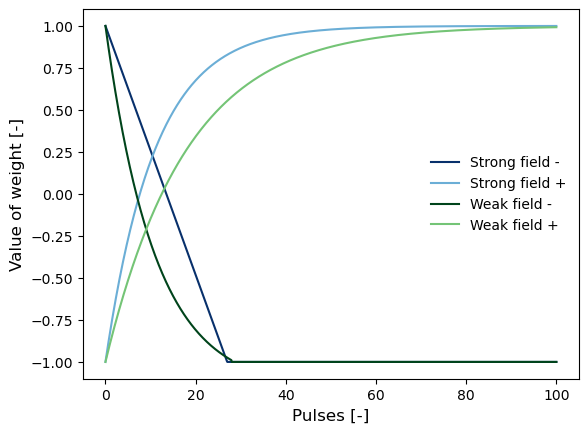

In [2]:
scale = 1
f_strong_minus = lambda x: ((-2*(1/27)*x + 2) * ((x < 27).float()) -1)*scale
f_strong_plus = lambda x: (1 - 2*torch.exp(-x/11))*scale 
f_weak_minus = lambda x: ((2.16*torch.exp(-x/11) - 0.16)* ((x < 28).float()) -1)*scale
f_weak_plus = lambda x: (1 - 2*torch.exp(-x/18))*scale
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## <a id='toc1_2_'></a>[Accuracy results](#toc0_)

The data is loaded from the simulation path and the data is saved and displayed.

In [3]:
n_iterations = 5
paths = [
    "20240711091649-MNIST-strong-0.01", # Strong field - LR 0.01
    "20240711091614-MNIST-weak-0.01", # Weak field - LR 0.01
    "20240711091723-MNIST-linear-0.01", # Linear field - LR 0.01
]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)

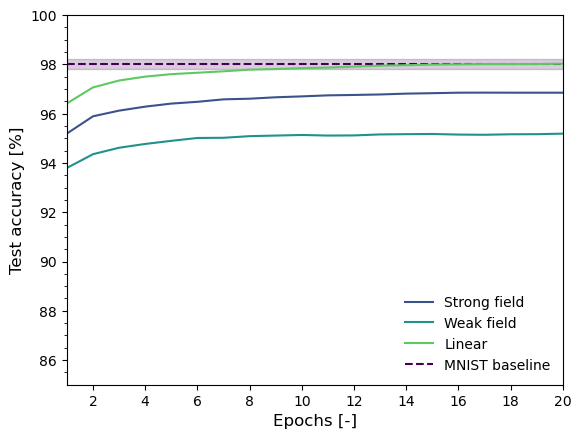

In [4]:
fig, ax = plt.subplots()
palette = plt.get_cmap('viridis', len(models)+2)
# Add mnist baseline 98% +- 0.2% for 512 hidden units
ax.hlines(98, 1, 20, color=palette(0), linestyle='--', label="MNIST baseline")
ax.fill_between([1, 20], 97.8, 98.2, alpha=0.2, color=palette(0))
# compare models
names = ["Strong field", "Weak field", "Linear"] 
for i, model in enumerate(models):
    mean = torch.mean(model, dim=0)
    std = torch.std(model, dim=0)
    # add one element to the beginning of the tensor
    mean = torch.cat((torch.tensor([0.0]), mean))
    std = torch.cat((torch.tensor([0.0]), std))
    ax.plot(mean*100, label=f"{names[i]}", color=palette(i+1))
    ax.fill_between(mean - std, mean + std, alpha=0.2, color=palette(i+1))

ax.set_xlabel("Epochs [-]", fontsize=12)
ax.set_ylabel("Test accuracy [%]", fontsize=12)
ax.legend(loc='lower right', fontsize=10, frameon=False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([85, 100])
ax.set_xticks(range(0, 21,2))
ax.set_xlim([1, 20])
plt.show()
# save as pdf and svg
name = "weak-vs-strong-" + GRAPHS_ID
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    

## <a id='toc1_3_'></a>[Weights analysis](#toc0_)

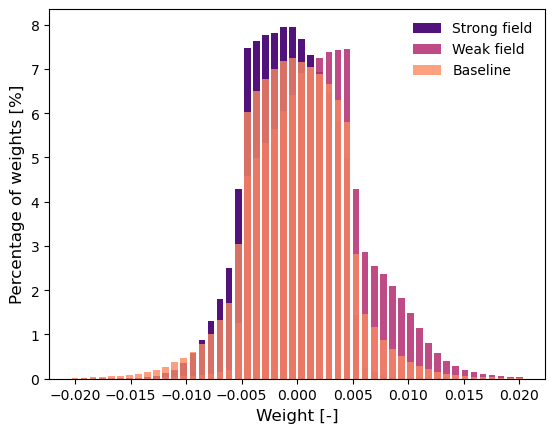

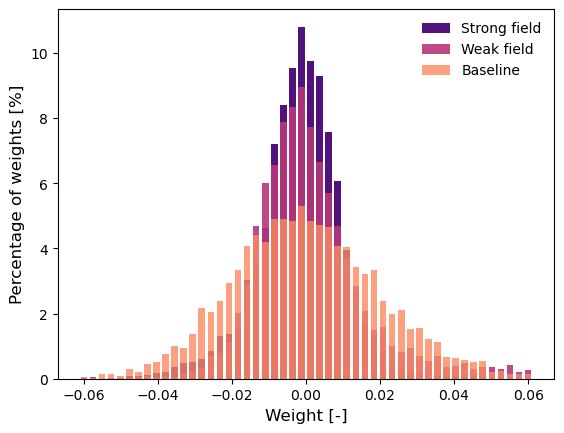

In [5]:
models = []
paths = [
    "20240711091649-MNIST-strong-0.01", # Strong field - LR 0.01
    "20240711091614-MNIST-weak-0.01", # Weak field - LR 0.01
    "20240711091723-MNIST-linear-0.01", # Linear field - LR 0.01
]
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    current_folder = os.path.join(SIMULATION_FOLDER, path)
    accuracies.append(torch.load(os.path.join(current_folder, path+f"-0.pth")))
    models.append(accuracies)
thresholds = [0.02, 0.06]
# weights keys (layers.1.weght)
keys = ["layers.1.weight", "layers.4.weight"]
for k, key in enumerate(keys):
    fig, ax = plt.subplots()
    palette = plt.get_cmap('magma', len(models)+2)
    # compare models
    names = ["Strong field", "Weak field", "Baseline"]
    for i, model in enumerate(models):
        weights = model[0][key].flatten()
        hist = torch.histc(weights, bins=50, min=-thresholds[k], max=thresholds[k]).to('cpu')
        # plot in % of the total weights
        ax.bar(torch.linspace(-thresholds[k], thresholds[k], 50), height=hist/len(weights)*100, width=0.03*thresholds[k], label=f"{names[i]}", color=palette(i+1), alpha=(1-0.1*i))
    ax.set_xlabel("Weight [-]", fontsize=12)
    ax.set_ylabel("Percentage of weights [%]", fontsize=12)
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    # save
    name = f"MNIST-weight-distribution-{key}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
    fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    plt.show()

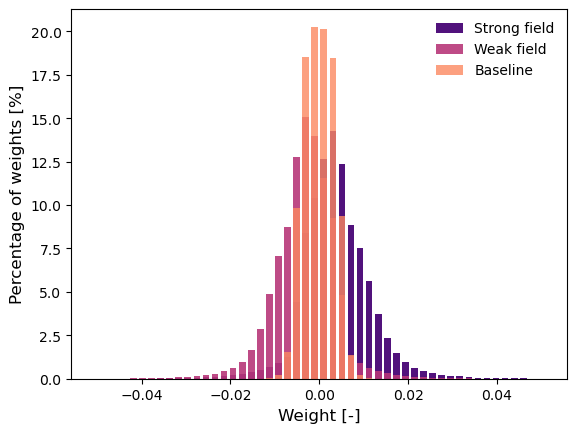

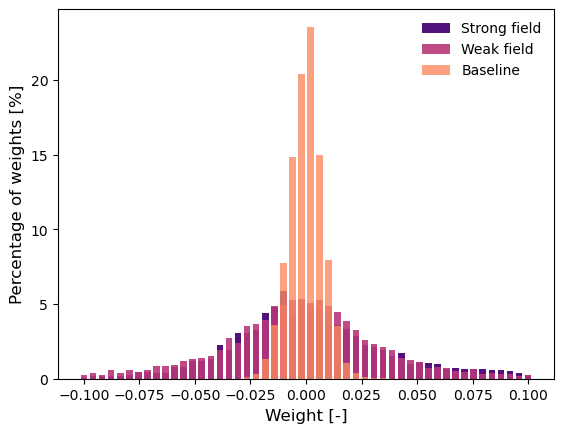

In [6]:
models = []
paths = [
    "20240711090043-Fashion-weak-0.1", # Strong field - LR 0.01
    "20240711090122-Fashion-strong-0.1", # Weak field - LR 0.01
    "20240711090508-Fashion-linear-0.001", # Linear field - LR 0.01
]
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    current_folder = os.path.join(SIMULATION_FOLDER, path)
    accuracies.append(torch.load(os.path.join(current_folder, path+f"-0.pth")))
    models.append(accuracies)
thresholds = [0.05, 0.1]
# weights keys (layers.1.weght)
keys = ["layers.1.weight", "layers.4.weight"]
for k, key in enumerate(keys):
    fig, ax = plt.subplots()
    palette = plt.get_cmap('magma', len(models)+2)
    # compare models
    names = ["Strong field", "Weak field", "Baseline"]
    for i, model in enumerate(models):
        weights = model[0][key].flatten()
        hist = torch.histc(weights, bins=50, min=-thresholds[k], max=thresholds[k]).to('cpu')
        # plot in % of the total weights
        ax.bar(torch.linspace(-thresholds[k], thresholds[k], 50), height=hist/len(weights)*100, width=0.03*thresholds[k], label=f"{names[i]}", color=palette(i+1), alpha=(1-0.1*i))
    ax.set_xlabel("Weight [-]", fontsize=12)
    ax.set_ylabel("Percentage of weights [%]", fontsize=12)
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    name = f"FashionMNIST-weight-distribution-{key}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
    fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    plt.show()

In [7]:
n_iterations = 5
paths = [
    "20240711091515-MNIST-strong-0.1", # Strong field - LR 0.1
    "20240711091440-MNIST-weak-0.1", # Weak field - LR 0.1
    "20240711091547-MNIST-linear-0.1", # Linear - LR 0.1
    "20240711091649-MNIST-strong-0.01", # Strong field - LR 0.01
    "20240711091614-MNIST-weak-0.01", # Weak field - LR 0.01
    "20240711091723-MNIST-linear-0.01", # Linear field - LR 0.01
    "20240711091827-MNIST-strong-0.001", # Strong field - LR 0.001
    "20240711091751-MNIST-weak-0.001", # Weak field - LR 0.001
    "20240711091900-MNIST-linear-0.001", # Linear field - LR 0.001
    "20240711094932-MNIST-weak-strong-0.1-switch-2",
    "20240711095025-MNIST-weak-strong-0.01-switch-2",
    "20240711095118-MNIST-weak-strong-0.001-switch-2",
    "20240711095212-MNIST-strong-weak-0.1-switch-2",
    "20240711095306-MNIST-strong-weak-0.01-switch-2",
    "20240711095358-MNIST-strong-weak-0.001-switch-2",
    "20240711094853-MNIST-weak-strong-0.1-switch-4",
    "20240711094927-MNIST-weak-strong-0.01-switch-4",
    "20240711095018-MNIST-weak-strong-0.001-switch-4",
    "20240711095111-MNIST-strong-weak-0.1-switch-4",
    "20240711095206-MNIST-strong-weak-0.01-switch-4",
    "20240711095300-MNIST-strong-weak-0.001-switch-4"
]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)
for path, model in zip(paths, models):
    model = model * 100
    mean = f"{model.mean(dim=0)[-1].item():.2f}"
    std = f"{model.std(dim=0)[-1].item():.2f}"
    print(f"{mean} +- {std} - {path}")

96.77 +- 0.09 - 20240711091515-MNIST-strong-0.1
94.62 +- 0.16 - 20240711091440-MNIST-weak-0.1
97.88 +- 0.05 - 20240711091547-MNIST-linear-0.1
96.85 +- 0.04 - 20240711091649-MNIST-strong-0.01
95.19 +- 0.10 - 20240711091614-MNIST-weak-0.01
98.03 +- 0.03 - 20240711091723-MNIST-linear-0.01
96.39 +- 0.06 - 20240711091827-MNIST-strong-0.001
94.84 +- 0.06 - 20240711091751-MNIST-weak-0.001
97.89 +- 0.05 - 20240711091900-MNIST-linear-0.001
96.53 +- 0.08 - 20240711094932-MNIST-weak-strong-0.1-switch-2
96.87 +- 0.10 - 20240711095025-MNIST-weak-strong-0.01-switch-2
96.25 +- 0.08 - 20240711095118-MNIST-weak-strong-0.001-switch-2
95.97 +- 0.06 - 20240711095212-MNIST-strong-weak-0.1-switch-2
95.90 +- 0.10 - 20240711095306-MNIST-strong-weak-0.01-switch-2
95.82 +- 0.08 - 20240711095358-MNIST-strong-weak-0.001-switch-2
97.10 +- 0.06 - 20240711094853-MNIST-weak-strong-0.1-switch-4
97.08 +- 0.10 - 20240711094927-MNIST-weak-strong-0.01-switch-4
96.68 +- 0.08 - 20240711095018-MNIST-weak-strong-0.001-switch-

In [8]:
n_iterations = 5
paths = [
    "20240711090122-Fashion-strong-0.1", # Strong field - LR 0.1
    "20240711090043-Fashion-weak-0.1", # Weak field - LR 0.1
    "20240711090155-Fashion-linear-0.1", # Linear - LR 0.1
    "20240711090256-Fashion-strong-0.01", # Strong field - LR 0.01
    "20240711090222-Fashion-weak-0.01", # Weak field - LR 0.01
    "20240711090330-Fashion-linear-0.01", # Linear field - LR 0.01
    "20240711090434-Fashion-strong-0.001", # Strong field - LR 0.001
    "20240711090357-Fashion-weak-0.001", # Weak field - LR 0.001
    "20240711090508-Fashion-linear-0.001", # Linear field - LR 0.001
    "20240711100627-Fashion-weak-strong-0.1-switch-2",
    "20240711100701-Fashion-weak-strong-0.01-switch-2",
    "20240711100735-Fashion-weak-strong-0.001-switch-2",
    "20240711100808-Fashion-strong-weak-0.1-switch-2",
    "20240711100841-Fashion-strong-weak-0.01-switch-2",
    "20240711100916-Fashion-strong-weak-0.001-switch-2",
    "20240711101217-Fashion-weak-strong-0.1-switch-4",
    "20240711101250-Fashion-weak-strong-0.01-switch-4",
    "20240711101325-Fashion-weak-strong-0.001-switch-4",
    "20240711101359-Fashion-strong-weak-0.1-switch-4",
    "20240711101433-Fashion-strong-weak-0.01-switch-4",
    "20240711101508-Fashion-strong-weak-0.001-switch-4"
]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)
for path, model in zip(paths, models):
    model = model * 100
    mean = f"{model.mean(dim=0)[-1].item():.2f}"
    std = f"{model.std(dim=0)[-1].item():.2f}"
    print(f"{mean} +- {std} - {path}")
    

87.61 +- 0.22 - 20240711090122-Fashion-strong-0.1
86.40 +- 0.11 - 20240711090043-Fashion-weak-0.1
87.50 +- 0.53 - 20240711090155-Fashion-linear-0.1
87.33 +- 0.02 - 20240711090256-Fashion-strong-0.01
86.29 +- 0.19 - 20240711090222-Fashion-weak-0.01
87.88 +- 0.39 - 20240711090330-Fashion-linear-0.01
86.61 +- 0.24 - 20240711090434-Fashion-strong-0.001
85.17 +- 0.09 - 20240711090357-Fashion-weak-0.001
88.30 +- 0.24 - 20240711090508-Fashion-linear-0.001
87.43 +- 0.16 - 20240711100627-Fashion-weak-strong-0.1-switch-2
87.52 +- 0.13 - 20240711100701-Fashion-weak-strong-0.01-switch-2
86.29 +- 0.12 - 20240711100735-Fashion-weak-strong-0.001-switch-2
86.13 +- 0.16 - 20240711100808-Fashion-strong-weak-0.1-switch-2
86.10 +- 0.07 - 20240711100841-Fashion-strong-weak-0.01-switch-2
85.29 +- 0.21 - 20240711100916-Fashion-strong-weak-0.001-switch-2
87.37 +- 0.03 - 20240711101217-Fashion-weak-strong-0.1-switch-4
87.47 +- 0.15 - 20240711101250-Fashion-weak-strong-0.01-switch-4
86.69 +- 0.18 - 202407111013